In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from math import sqrt
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from matplotlib import pyplot as plt

# nome para salvar as figuras
n = str(10)
figname = 'multi1-' + n

# carregar e preparar o dataset
dataset = read_csv('df_unificado.csv', index_col=0)

# filtrar a partir da data escolhida na etapa de exploração
filtro = (dataset.index>='2016-07-01')
dataset = dataset.loc[filtro]

dataset.index.name = 'Data'

# remover colunas que não serão utilizadas
dataset.drop('Unique_Addresses', axis=1, inplace=True)
dataset.drop('Transactions', axis=1, inplace=True)
dataset.drop('Total_Bitcoins', axis=1, inplace=True)
dataset.drop('Volume', axis=1, inplace=True)
dataset.drop('Difficulty', axis=1, inplace=True)

# sumário do dataset
print(dataset)

               Price_USD     Marketcap
Data                                  
2016-07-01    672.515015  1.063267e+10
2016-07-02    676.734009  1.106617e+10
2016-07-03    704.968018  1.036046e+10
2016-07-04    658.804016  1.075623e+10
2016-07-05    683.208984  1.055359e+10
...                  ...           ...
2021-07-02  33549.600177  6.354508e+11
2021-07-03  33854.421362  6.499397e+11
2021-07-04  34665.564866  6.615748e+11
2021-07-05  35284.344430  6.326962e+11
2021-07-06  33723.509655  6.418992e+11

[1832 rows x 2 columns]


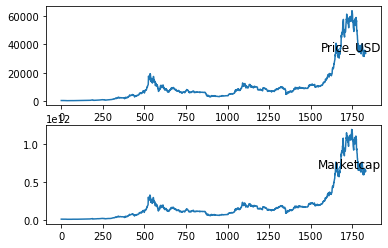

In [2]:
# preparar dataset
valores = dataset.values

# especificar colunas para plotar
colunas = [0, 1]
i = 1

# plotar cada coluna
plt.figure()
for coluna in colunas:
    plt.subplot(len(colunas), 1, i)
    plt.plot(valores[:, coluna])
    plt.title(dataset.columns[coluna], y=0.5, loc='right')
    i += 1
plt.show()

In [3]:
# função conversora de série para aprendizado supervisionado
def serie_para_supervisionado(dados, n_in=1, n_out=1, dropnulos=True):
    n_vars = 1 if type(dados) is list else dados.shape[1]
    df = DataFrame(dados)
    cols, nomes = list(), list()
    # sequência de inputs (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    nomes += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # sequência de previsões (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            nomes += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            nomes += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # juntar tudo
    retorno = concat(cols, axis=1)
    retorno.columns = nomes
    # remover linhas com valores nulos
    if dropnulos:
        retorno.dropna(inplace=True)
    return retorno

# garantir que todos os dados são float
valores = valores.astype('float32')

# normalizar variáveis
normalizador = MinMaxScaler(feature_range=(0, 1))
valores_normalizados = normalizador.fit_transform(valores)

# reestruturar para aprendizado supervisionado
reestruturado = serie_para_supervisionado(valores_normalizados, 1, 1)

# remover colunas que não desejamos prever
print(reestruturado)
reestruturado.drop(reestruturado.columns[[3]], axis=1, inplace=True)
print(reestruturado)

      var1(t-1)  var2(t-1)   var1(t)   var2(t)
1      0.001967   0.001688  0.002034  0.002056
2      0.002034   0.002056  0.002482  0.001457
3      0.002482   0.001457  0.001749  0.001793
4      0.001749   0.001793  0.002137  0.001621
5      0.002137   0.001621  0.001933  0.001712
...         ...        ...       ...       ...
1827   0.547634   0.527031  0.524032  0.532220
1828   0.524032   0.532220  0.528872  0.544523
1829   0.528872   0.544523  0.541752  0.554402
1830   0.541752   0.554402  0.551578  0.529881
1831   0.551578   0.529881  0.526793  0.537696

[1831 rows x 4 columns]
      var1(t-1)  var2(t-1)   var1(t)
1      0.001967   0.001688  0.002034
2      0.002034   0.002056  0.002482
3      0.002482   0.001457  0.001749
4      0.001749   0.001793  0.002137
5      0.002137   0.001621  0.001933
...         ...        ...       ...
1827   0.547634   0.527031  0.524032
1828   0.524032   0.532220  0.528872
1829   0.528872   0.544523  0.541752
1830   0.541752   0.554402  0.551578
1831

In [4]:
# separar em sets de treino e de teste
valores = reestruturado.values
n_dias_treinamento = len(valores) - 217
treino = valores[:n_dias_treinamento, :]
teste = valores[n_dias_treinamento:, :]

# separar em inputs e outputs
treino_X, treino_y = treino[:, :-1], treino[:, -1]
teste_X, teste_y = teste[:, :-1], teste[:, -1]

# reestruturar para 3D [samples, timesteps, features]
treino_X = treino_X.reshape((treino_X.shape[0], 1, treino_X.shape[1]))
teste_X = teste_X.reshape((teste_X.shape[0], 1, teste_X.shape[1]))
print(treino_X.shape, treino_y.shape, teste_X.shape, teste_y.shape)

(1614, 1, 2) (1614,) (217, 1, 2) (217,)


In [5]:
# preparar a rede neural
modelo = Sequential()
modelo.add(LSTM(30, input_shape=(treino_X.shape[1], treino_X.shape[2])))
modelo.add(Dropout(0.3))
modelo.add(Dense(1))
modelo.compile(loss='mean_squared_error', optimizer='adam')

callback_treinamento = keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

# treinar o modelo
historico = modelo.fit(treino_X, treino_y, epochs=300, batch_size=32, validation_data=(teste_X, teste_y), verbose=2, shuffle=False, callbacks=[callback_treinamento])

Epoch 1/300
51/51 - 1s - loss: 0.0047 - val_loss: 0.2951
Epoch 2/300
51/51 - 0s - loss: 0.0039 - val_loss: 0.2398
Epoch 3/300
51/51 - 0s - loss: 0.0034 - val_loss: 0.1936
Epoch 4/300
51/51 - 0s - loss: 0.0028 - val_loss: 0.1492
Epoch 5/300
51/51 - 0s - loss: 0.0023 - val_loss: 0.1085
Epoch 6/300
51/51 - 0s - loss: 0.0018 - val_loss: 0.0713
Epoch 7/300
51/51 - 0s - loss: 0.0014 - val_loss: 0.0422
Epoch 8/300
51/51 - 0s - loss: 9.8373e-04 - val_loss: 0.0190
Epoch 9/300
51/51 - 0s - loss: 7.2228e-04 - val_loss: 0.0067
Epoch 10/300
51/51 - 0s - loss: 4.6413e-04 - val_loss: 0.0013
Epoch 11/300
51/51 - 0s - loss: 3.5639e-04 - val_loss: 4.0099e-04
Epoch 12/300
51/51 - 0s - loss: 2.7450e-04 - val_loss: 0.0016


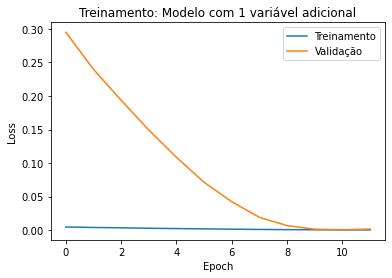

In [6]:
# plotar histórico de treinamento
plt.title('Treinamento: Modelo com 1 variável adicional')
plt.plot(historico.history['loss'], label='Treinamento')
plt.plot(historico.history['val_loss'], label='Validação')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig(figname+'-train.png', bbox_inches='tight')
plt.show()

In [7]:
# fazer a previsão
previsao = modelo.predict(teste_X)
teste_X = teste_X.reshape((teste_X.shape[0], teste_X.shape[2]))

# desfazer a normalização dos valores da previsão
previsao_reescala = concatenate((previsao, teste_X[:, 1:]), axis=1)
previsao_reescala = normalizador.inverse_transform(previsao_reescala)
previsao_reescala_rmse = previsao_reescala[:,0]

# desfazer a normalização dos valores reais
teste_y = teste_y.reshape((len(teste_y), 1))
teste_reescala = concatenate((teste_y, teste_X[:, 1:]), axis=1)
teste_reescala = normalizador.inverse_transform(teste_reescala)
teste_reescala_rmse = teste_reescala[:,0]

# calcular RMSE
rmse = sqrt(mean_squared_error(teste_reescala_rmse, previsao_reescala_rmse))
print('Teste RMSE: %.3f' % rmse)

Teste RMSE: 2531.770


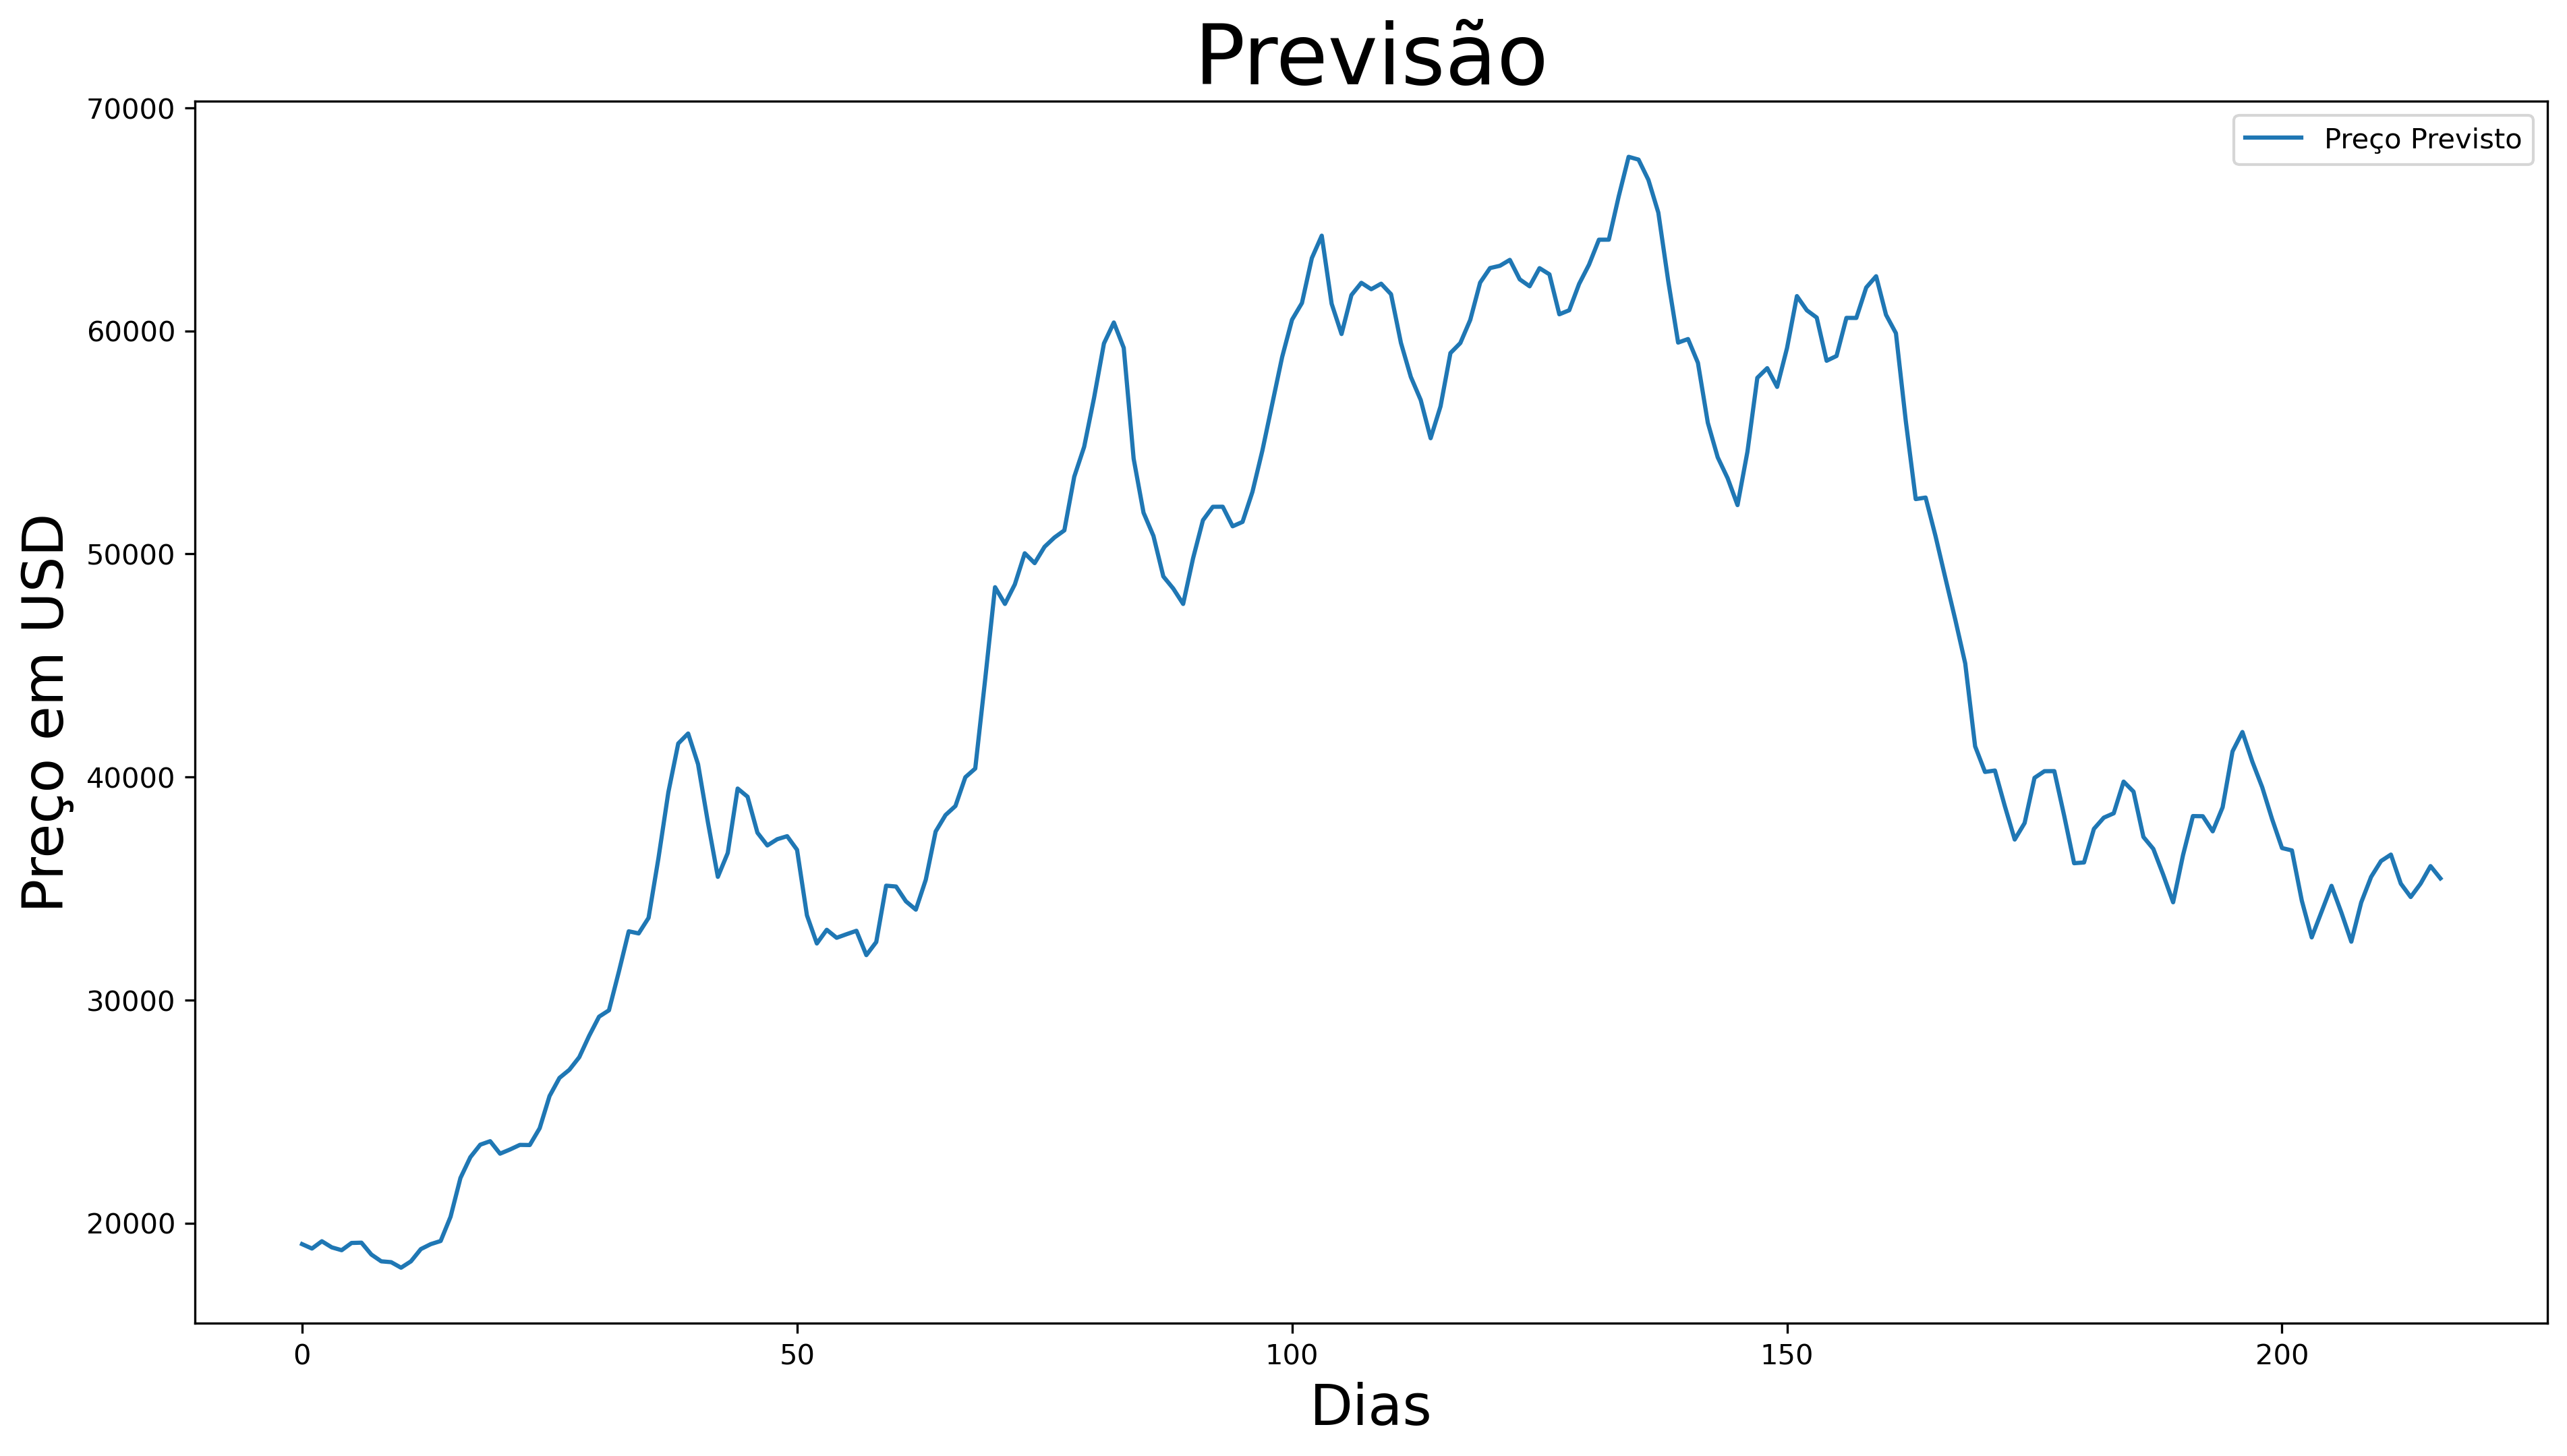

In [8]:
plt.figure(figsize=(15, 8), dpi=300, facecolor = 'w', edgecolor = 'k')

plt.plot(previsao_reescala[:, 0], label = 'Preço Previsto')

plt.title('Previsão', fontsize = 30)
plt.xlabel('Dias', fontsize=20)
plt.ylabel('Preço em USD', fontsize = 20)
plt.legend(loc = 'best')
plt.show()

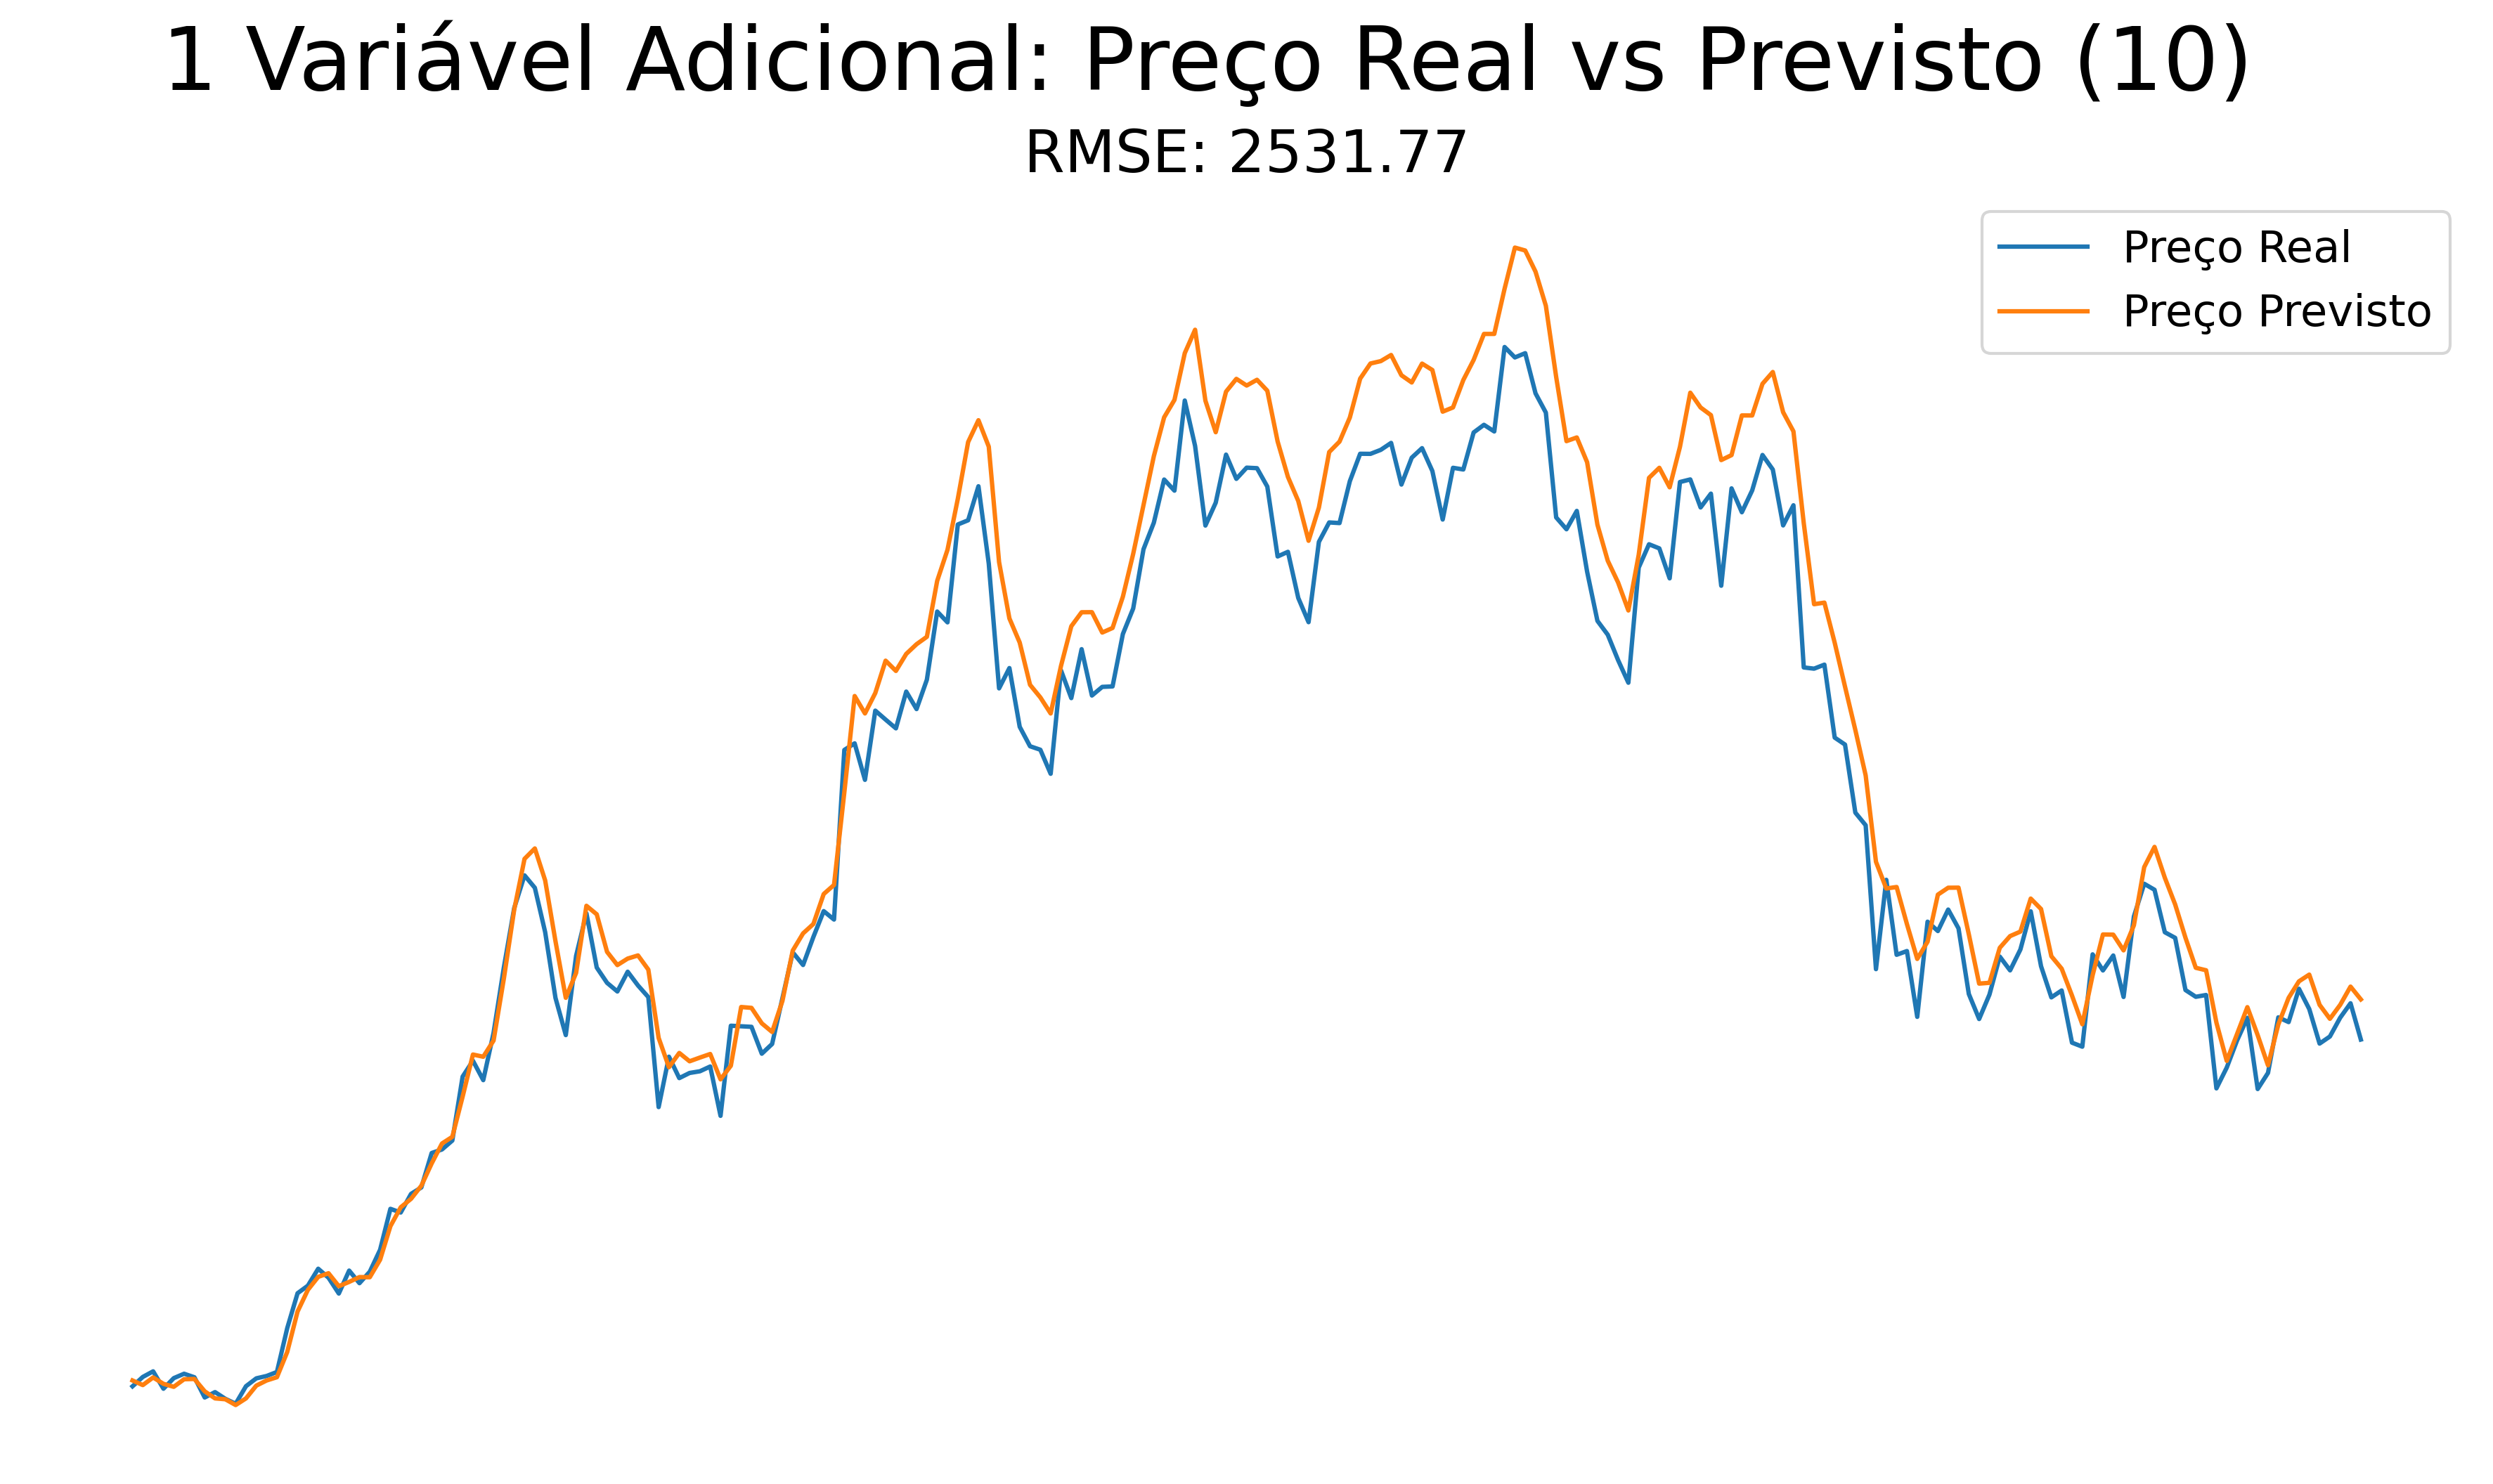

In [9]:
# grafico previsão vs real
plt.figure(figsize=(15, 8), dpi=300, facecolor = 'w', edgecolor = 'k')

plt.plot(teste_reescala[:, 0], label = 'Preço Real')
plt.plot(previsao_reescala[:, 0], label='Preço Previsto')

plt.suptitle('1 Variável Adicional: Preço Real vs Previsto ('+n+')', fontsize = 30)
plt.title('RMSE: %.2f' % rmse, fontsize=20)
#plt.xlabel('Dias', fontsize=20)
#plt.ylabel('Preço em USD', fontsize = 20)
plt.axis('off')
plt.legend(loc = 'best', fontsize=15)
plt.savefig(figname+'-graf.png', bbox_inches='tight')
plt.show()